# Data Preparation, Pipelines & Model 

In [1]:
# Modules importeren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import joblib

In [2]:
# Dataset importeren 
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv")

In [3]:
print(df['time_signature'].value_counts(dropna=False))

time_signature
4    17754
3      772
5      233
1       73
0        3
Name: count, dtype: int64


In [4]:
df = df[df['time_signature'] > 1]

In [5]:
# Target variabele maken 
target = 'song_popularity'

### Phase 3: Data Preparation

In [6]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18759
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14402


In [7]:
df.drop(columns=["song_name"], inplace=True) # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken 

In [8]:
X = df.drop(columns=[target], axis=1)
y = df[target]

In [9]:
print(X['key'].unique())

[ 8  3  0 10  4  2  1  9  7 11  5  6]


In [10]:
# Zorg dat 'key' en 'time_signature' als categorisch gezien worden
X['time_signature'] = X['time_signature'].astype(str)
X['key'] = X['key'].astype(int)  # blijft numeriek voor de cyclische encoder

## Key Cyclic Encoder class 

In [11]:
class ToonsoortCyclischeEncoder(BaseEstimator, TransformerMixin):
    """
    Cyclisch encoden van de toonsoort/key (0-11) met sinus en cosinus. 
    """

    def __init__(self, kolom='key', max_waarde=12):
        self.kolom = kolom
        self.max_waarde = max_waarde
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X = X.copy()
        k = X[self.kolom]
        X[f'{self.kolom}_sin'] = np.sin(2 * np.pi * k/self.max_waarde)
        X[f'{self.kolom}_cos'] = np.cos(2 * np.pi * k/self.max_waarde)
        return X.drop(columns=[self.kolom])
    
    def get_feature_names_out(self, input_features=None):
        return np.array([f'{self.kolom}_sin', f'{self.kolom}_cos'])

In [12]:
class OutlierCleaner(BaseEstimator, TransformerMixin):
    """Markeert en vervangt extreme outliers met NaN of limietwaarden."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        # Logica uit uitschieters functie data exploratie notebook toepassen
        X.loc[(X['song_duration_ms'] < 30_000) | (X['song_duration_ms'] > 1_200_000), 'song_duration_ms'] = np.nan
        X.loc[(X['tempo'] < 30) | (X['tempo'] > 250), 'tempo'] = np.nan
        X.loc[(X['loudness'] < -60) | (X['loudness'] > 0), 'loudness'] = np.nan

        for col in ['danceability', 'energy', 'audio_valence', 'instrumentalness', 'liveness', 'speechiness']:
            if col in X.columns:
                X.loc[(X[col] < 0) | (X[col] > 1), col] = np.nan

        if 'time_signature' in X.columns:
            X.loc[~X['time_signature'].isin([3, 4, 5]), 'time_signature'] = np.nan

        # NaN's vervangen met medianen
        X.fillna(X.median(numeric_only=True), inplace=True)
        return X

In [13]:
def get_feature_names_from_column_transformer(ct):
    """Haalt feature names uit een ColumnTransformer, ook als nested pipelines aanwezig zijn."""
    output_features = []

    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            output_features.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(cols)
                output_features.extend(names)
            except:
                output_features.extend(cols)
        elif hasattr(transformer, 'transformers_'):  # nested ColumnTransformer
            output_features.extend(get_feature_names_from_column_transformer(transformer))
        elif isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    names = last_step.get_feature_names_out(cols)
                    output_features.extend(names)
                except:
                    output_features.extend(cols)
            else:
                output_features.extend(cols)
        else:
            output_features.extend(cols)
    return output_features

### Phase 4: Modeling 

Supervised learning, omdat je de uitkomst al hebt 
<br>
Supervised learning heeft 2 hoofdtakken: regressie en classificatie 
<br>
RMSE 
<br>
Meervoudige lineare regressie 
<br>
Logistieke lineare regressie is classification 
<br>
Random forests is het begin van dat machine learning slim werd 

In [14]:
def nieuwe_features(df):
    df = df.copy()
    df['valence_dance'] = df['audio_valence'] * df['danceability']
    
    # Ratio features
    df['acoustic_dance_ratio'] = df['acousticness'] / (df['danceability'] + 0.001) # Kleine constante (0.001) toegevoegd om deling door nul te vermijden als een waarde in een van de kolommen nul is 
    df['duration_energy_ratio'] = df['song_duration_ms'] / (df['energy'] + 0.001) 
    
    return df
feature_engineering = FunctionTransformer(nieuwe_features, validate=False)

In [15]:
# Kolommen indelen
kolommen_winsoriseren = ['song_duration_ms', 'tempo']
categorische_kolommen = ['time_signature']
cyclische_kolommen = ['key']
engineered_features = [
    'energy_dance', 'valence_dance',
    'acoustic_dance_ratio', 'duration_energy_ratio'
]

# Alle numerieke kolommen behalve target
numerieke_kolommen = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Alle numerieke kolommen behalve target
overige_kolommen = [
    c for c in numerieke_kolommen
    if c not in kolommen_winsoriseren + cyclische_kolommen + categorische_kolommen
]

In [16]:
# Train en test set maken 
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state = 42
)

In [17]:
print("Numeriek:", numerieke_kolommen)
print("Overige:", overige_kolommen)

Numeriek: ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'audio_valence']
Overige: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'audio_valence']


In [18]:
skewed_cols = ['acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness']

## Preprocessors

In [19]:
# Kolommen definiëren
categorische_kolommen = ['time_signature']
cyclische_kolommen = ['key']

yeo_cols = [
    'danceability', 'audio_valence', 'energy', 'loudness',
    'instrumentalness', 'liveness', 'speechiness',
    'acoustic_dance_ratio', 'duration_energy_ratio'
]

log_cols = ['song_duration_ms']

preprocessor = ColumnTransformer([
    # Log-transformatie
    ('log', Pipeline([
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', StandardScaler())
    ]), log_cols),

    # Yeo-Johnson transformatie
    ('yeo', Pipeline([
        ('yeo', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), yeo_cols),

    # One-hot encoding
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorische_kolommen),

    # Cyclische encoding van key
    ('key_cyclisch', Pipeline([
        ('encoder', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12)),
        ('scaler', StandardScaler())
    ]), cyclische_kolommen),

    # Overige numerieke kolommen schalen
    ('scale_rest', StandardScaler(),
     [c for c in X.columns
      if c not in yeo_cols + log_cols + categorische_kolommen + cyclische_kolommen
      and c != 'song_popularity'
     ] + ['valence_dance'])
],
remainder='drop')

## Pipelines

In [20]:
# Lineaire Regressie pipeline 
lineair_pipeline = Pipeline([
    ('clean_outliers', OutlierCleaner()),
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

In [21]:
# Random Forest pipeline
random_forest_pipeline = Pipeline([
    ('clean_outliers', OutlierCleaner()),
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [22]:
# Trainen en evalueren 
lineair_pipeline.fit(X_train, y_train)
y_pred = lineair_pipeline.predict(X_test)

## Fase 1: RandomizedSearchCV

In [ ]:
# Broad parameter ranges
param_dist = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': randint(4, 16),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=random_forest_pipeline,
    param_distributions=param_dist,
    n_iter=25,          # number of random combinations to test
    scoring='r2',
    cv=3,               # fewer folds = faster
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best parameters (random search):", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# (Optional) Save for later
import joblib
joblib.dump(random_search, "random_search_rf.pkl")

# Store the best params for grid refinement
best = random_search.best_params_

Best parameters (random search): {'model__max_depth': 8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 373}
<br>
Best CV R²: 0.048560745616011945

## Fase 2: GridSearchCV 

In [ ]:
# Define a tighter grid around the best RandomizedSearchCV result
param_grid = {
    'model__n_estimators': [best['model__n_estimators'] - 50,
                            best['model__n_estimators'],
                            best['model__n_estimators'] + 50],
    'model__max_depth': [best['model__max_depth'] - 2,
                         best['model__max_depth'],
                         best['model__max_depth'] + 2],
    'model__min_samples_split': [best['model__min_samples_split'] - 1,
                                 best['model__min_samples_split'],
                                 best['model__min_samples_split'] + 1],
    'model__min_samples_leaf': [best['model__min_samples_leaf'] - 1,
                                best['model__min_samples_leaf'],
                                best['model__min_samples_leaf'] + 1]
}

# Remove invalid (≤ 0) values
for key, vals in param_grid.items():
    param_grid[key] = [v for v in vals if v > 0]

# Define grid search
grid_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters (grid refinement):", grid_search.best_params_)
print("Cross-val R²:", grid_search.best_score_)

# Save the trained grid search for later use
import joblib
joblib.dump(grid_search, "grid_search_rf.pkl")

Best parameters (grid refinement): {'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 7, 'model__n_estimators': 423}
<br>
Cross-val R²: 0.052337569961827056

In [29]:
grid_search = joblib.load("grid_search_rf.pkl")

In [30]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define KFold (5 splits, shuffled for randomness)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Linear Regression
scores_lin = cross_val_score(lineair_pipeline, X, y, cv=kfold,
                             scoring=make_scorer(r2_score))

# Evaluate Random Forest
scores_rf = cross_val_score(random_forest_pipeline, X, y, cv=kfold,
                            scoring=make_scorer(r2_score))

print("Linear Regression R² per fold:", scores_lin)
print("Random Forest R² per fold:", scores_rf)
print("Mean ± SD (Linear):", np.mean(scores_lin), "±", np.std(scores_lin))
print("Mean ± SD (Random Forest):", np.mean(scores_rf), "±", np.std(scores_rf))


# Custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: 
                          root_mean_squared_error(y_true, y_pred),
                          greater_is_better=False)

# Add RMSE cross-val
scores_rf_rmse = cross_val_score(random_forest_pipeline, X, y, cv=kfold, scoring=rmse_scorer)
print("Random Forest RMSE per fold:", -scores_rf_rmse)


Linear Regression R² per fold: [0.04115335 0.03094977 0.02884604 0.03164331 0.02948538]
Random Forest R² per fold: [0.0536665  0.02553238 0.03915305 0.04537676 0.02043654]
Mean ± SD (Linear): 0.032415569046555 ± 0.004481546041439355
Mean ± SD (Random Forest): 0.03683304541493171 ± 0.012314975615554134
Random Forest RMSE per fold: [19.53526073 20.00037386 19.69204619 20.14059602 20.12646102]


In [31]:
from scipy.stats import ttest_rel

# Perform a paired t-test on the cross-validation R² scores
t_stat, p_val = ttest_rel(scores_rf, scores_lin)

print(f"T-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# Interpretation
if p_val < 0.05:
    print("Significant difference: Random Forest and Linear Regression perform differently.")
else:
    print("No statistically significant difference detected.")

T-statistic = 0.9161, p-value = 0.4115
No statistically significant difference detected.


## Evaluatie test data

In [32]:
beste_model = grid_search.best_estimator_
y_pred_rf = beste_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

print(f"Test R²: {r2_rf:.4f}")
print(f"Test RMSE: {rmse_rf:.4f}")

Test R²: 0.0715
Test RMSE: 19.3504


## Resultaten vergelijken

In [33]:
y_pred_lin = lineair_pipeline.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = root_mean_squared_error(y_test, y_pred_lin)

resultaten = pd.DataFrame({
    'Model': ['Lineaire regressie', 'Random Forest'],
    'R2': [r2_lin, r2_rf],
    'RMSE': [rmse_lin, rmse_rf]
}).round({'R2': 4, 'RMSE': 2})

display(resultaten)

,Model,R2,RMSE
0,Lineaire regressie,0.0411,19.66
1,Random Forest,0.0715,19.35


### Observaties resultaten 

Random forest presteert beter dan lineare regressie: R² iets omhoog en RMSE iets omlaag. 
<br>
RMSE van 20 is logisch, omdat je populariteit niet alleen op basis van audio features kunt voorspellen. 

### Feature Importances

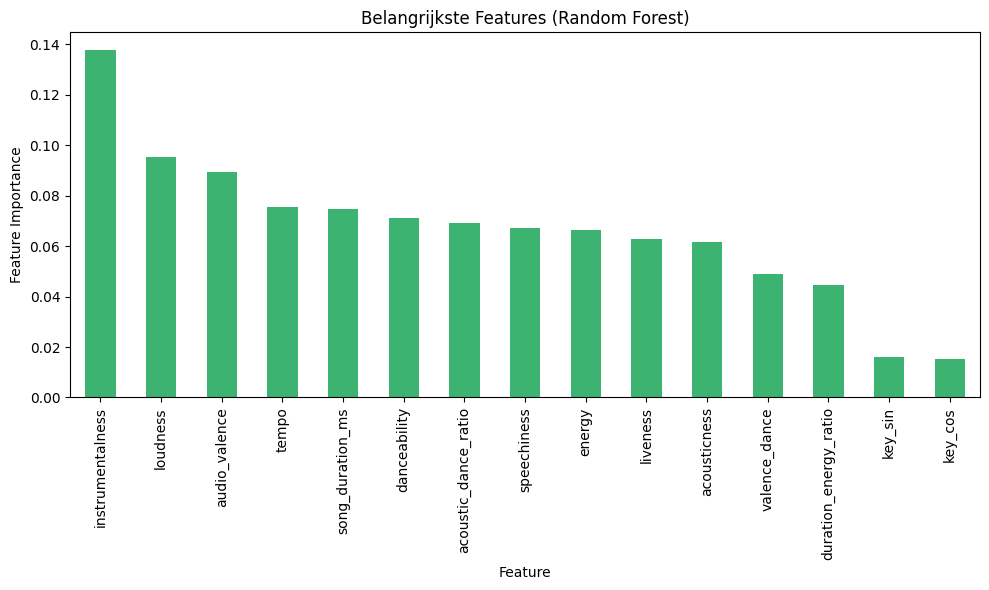

In [34]:
model = grid_search.best_estimator_.named_steps['model']
importances = model.feature_importances_

# Use helper to get feature names
preprocessor = grid_search.best_estimator_.named_steps['preprocess']
feature_names = get_feature_names_from_column_transformer(preprocessor)

# Create series and sort 
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#Plot top 15 belangrijke features

plt.figure(figsize=(10, 6))
feat_importance.head(15).plot(kind='bar', color='mediumseagreen')
plt.title("Belangrijkste Features (Random Forest)")
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [35]:
print(feat_importance.to_string())

instrumentalness         0.137807
loudness                 0.095309
audio_valence            0.089473
tempo                    0.075401
song_duration_ms         0.074831
danceability             0.071160
acoustic_dance_ratio     0.069078
speechiness              0.067240
energy                   0.066198
liveness                 0.062751
acousticness             0.061578
valence_dance            0.048922
duration_energy_ratio    0.044397
key_sin                  0.016107
key_cos                  0.015179
audio_mode               0.004568
time_signature_nan       0.000000


In [36]:
print(X_train.shape, X_test.shape)

(11521, 13) (2881, 13)


In [ ]:
X_transformed = lineair_pipeline[:-1].fit_transform(X_train)
print(X_transformed.shape)

(11521, 17)
